In [1]:
cd /home/mffang/workspace/Poisson-regression

/home/mffang/workspace/Poisson-regression


In [2]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import RADOM
print(RADOM.__version__)

from RADOM.inference import Trajectory
from RADOM.mixtures import PoissonMixture, GammaPoissonMixture
from RADOM.preprocess import *
from RADOM.plotting import *

2023.06.07


In [5]:
from scipy.stats import spearmanr
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmasher as cmr
from tqdm import tqdm

# Load data

In [6]:
alldata = sc.read('data/bone_marrow.h5ad')
alldata

AnnData object with n_obs × n_vars = 5780 × 14319
    obs: 'clusters', 'palantir_pseudotime'
    uns: 'clusters_colors'
    obsm: 'X_tsne'
    layers: 'spliced', 'unspliced'

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


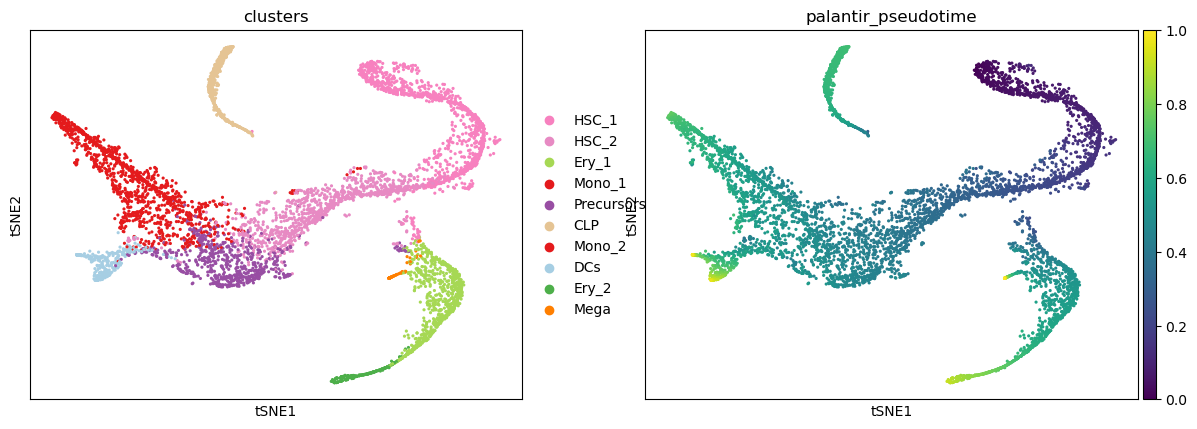

In [7]:
sc.pl.tsne(alldata,color=['clusters', 'palantir_pseudotime'])

In [8]:
alldata.var_names

Index(['FO538757.1', 'AP006222.2', 'RP4-669L17.10', 'LINC00115', 'FAM41C',
       'RP11-54O7.3', 'NOC2L', 'HES4', 'RNF223', 'TNFRSF18',
       ...
       'AC010084.1', 'PCDH11Y', 'TBL1Y', 'TTTY15', 'USP9Y', 'DDX3Y', 'TMSB4Y',
       'FAM224A', 'EIF1AY', 'RPS4Y2'],
      dtype='object', name='index', length=14319)

In [9]:
marker_genes = ['CD34','CD36','CD10','TFRC','CD135','ITGA2B','IL3RA']

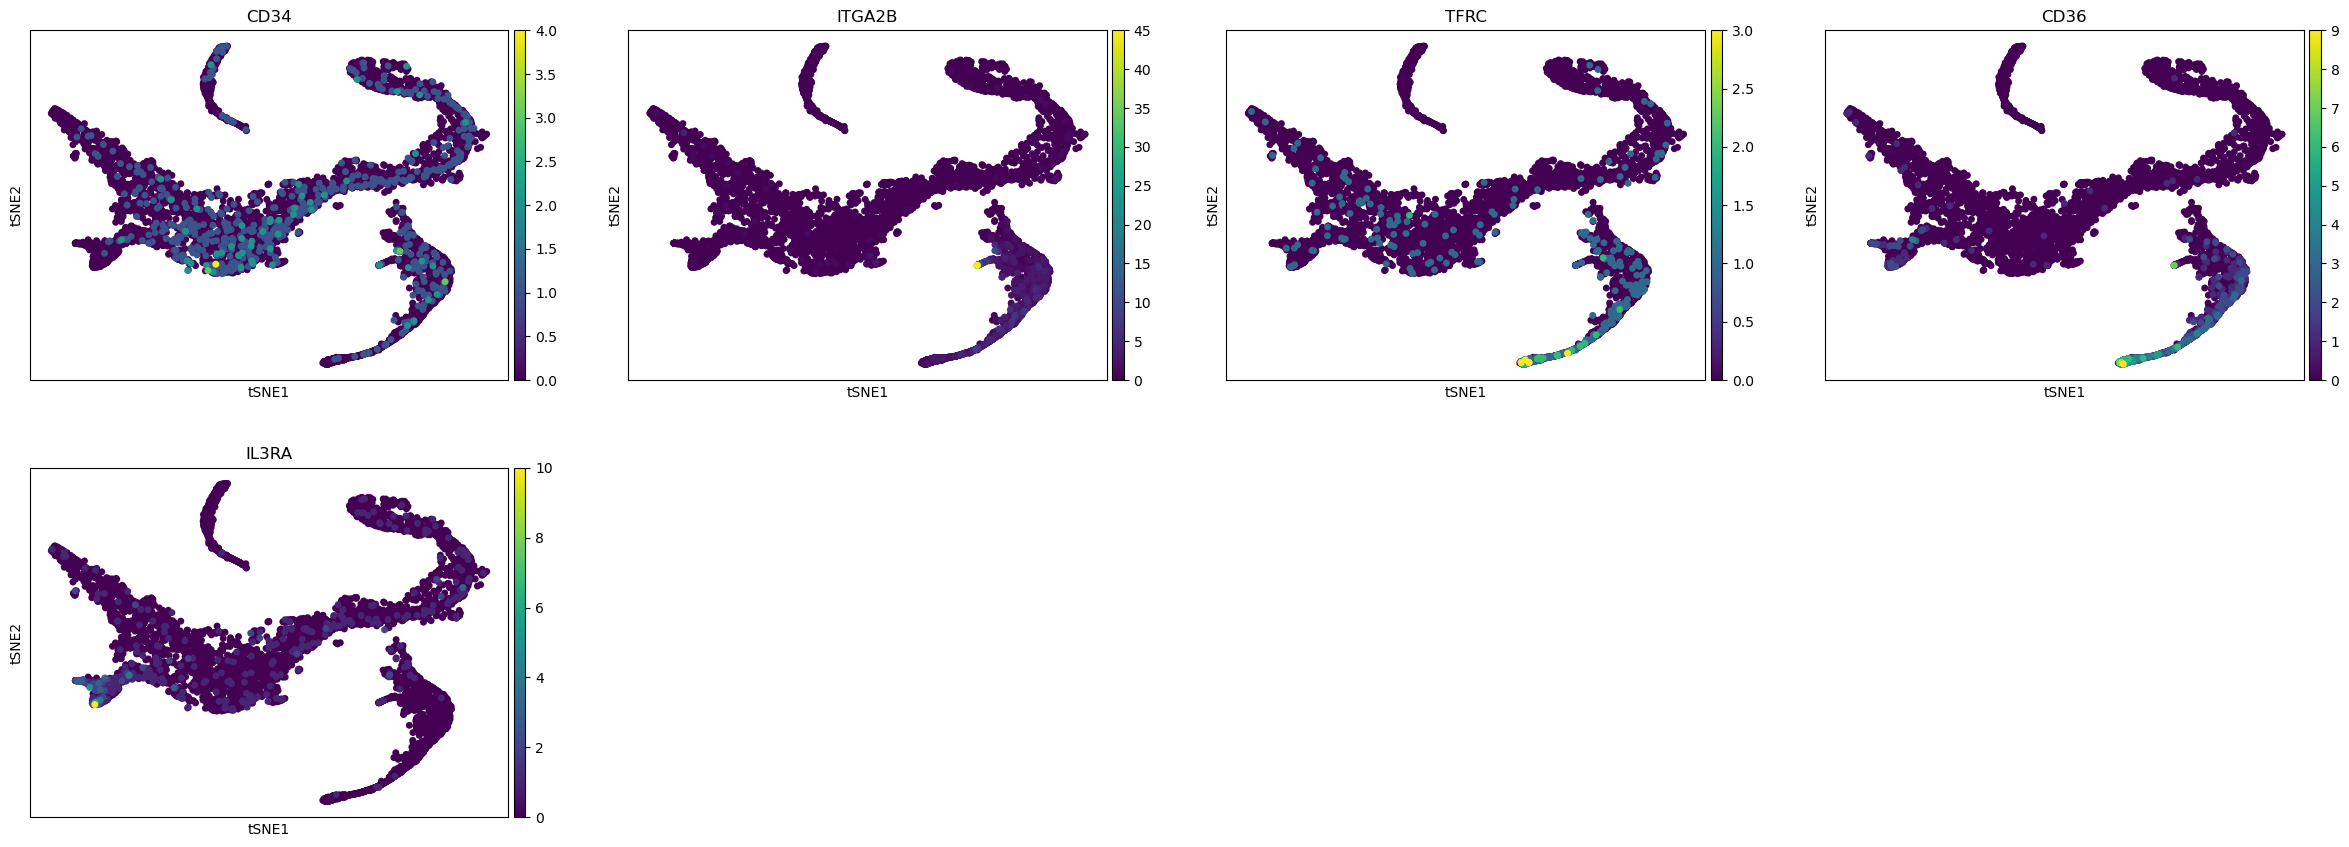

In [10]:
sc.pl.tsne(alldata,color=alldata.var_names[alldata.var_names.isin(marker_genes)],s=100)

In [11]:
adata = alldata[alldata.obs['clusters'].isin(['HSC_1', 'HSC_2', 'Precursors','Ery_1','Ery_2'])]
adata

View of AnnData object with n_obs × n_vars = 3775 × 14319
    obs: 'clusters', 'palantir_pseudotime'
    uns: 'clusters_colors'
    obsm: 'X_tsne'
    layers: 'spliced', 'unspliced'

In [12]:
clusters = adata.obs["clusters"]
Clusters = ['HSC_1', 'HSC_2', 'Precursors','Ery_1','Ery_2']

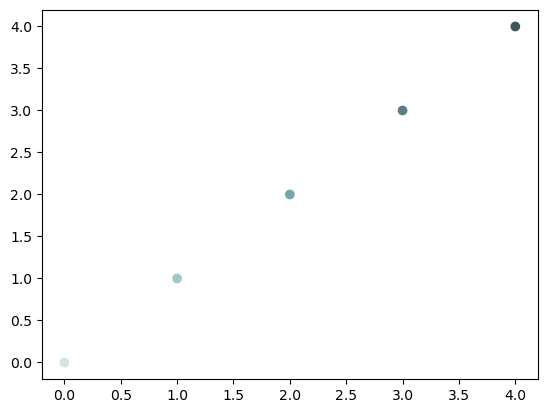

In [13]:
color_palette = ["#d3e4e2","#77a6ac","#405759"]
from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(Clusters))

cell_colors = np.zeros((adata.n_obs,3))

for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    cell_colors[idx] = cmap_cluster(i)[:3]
plt.scatter(x=np.arange(len(Clusters)), y=np.arange(len(Clusters)),c=cmap_cluster(np.arange(len(Clusters))))

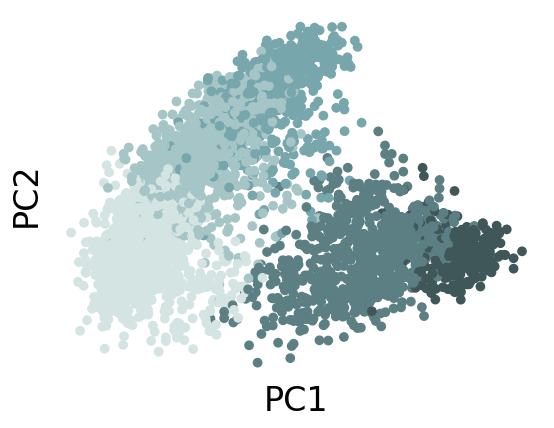

In [14]:
from sklearn.decomposition import PCA

total_UMI = adata.X.toarray().sum(axis=1)
r = total_UMI/np.mean(total_UMI)
pca = PCA(n_components=2)
x = pca.fit_transform(np.log(1+adata.X.toarray()/total_UMI[:,None]*np.mean(total_UMI)))
adata.obsm['X_pca']=x

fig, ax = plt.subplots(1,1)
ax.scatter(x[:,0],x[:,1],c=cell_colors);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

In [15]:
gene_length_file = np.loadtxt("data/gg_200524_mouse_genome_polyA_cum_1.txt",dtype="str")
gene_length = np.array([int(gene[1]) for gene in gene_length_file])
gene_name = np.array([gene[0].upper() for gene in gene_length_file])

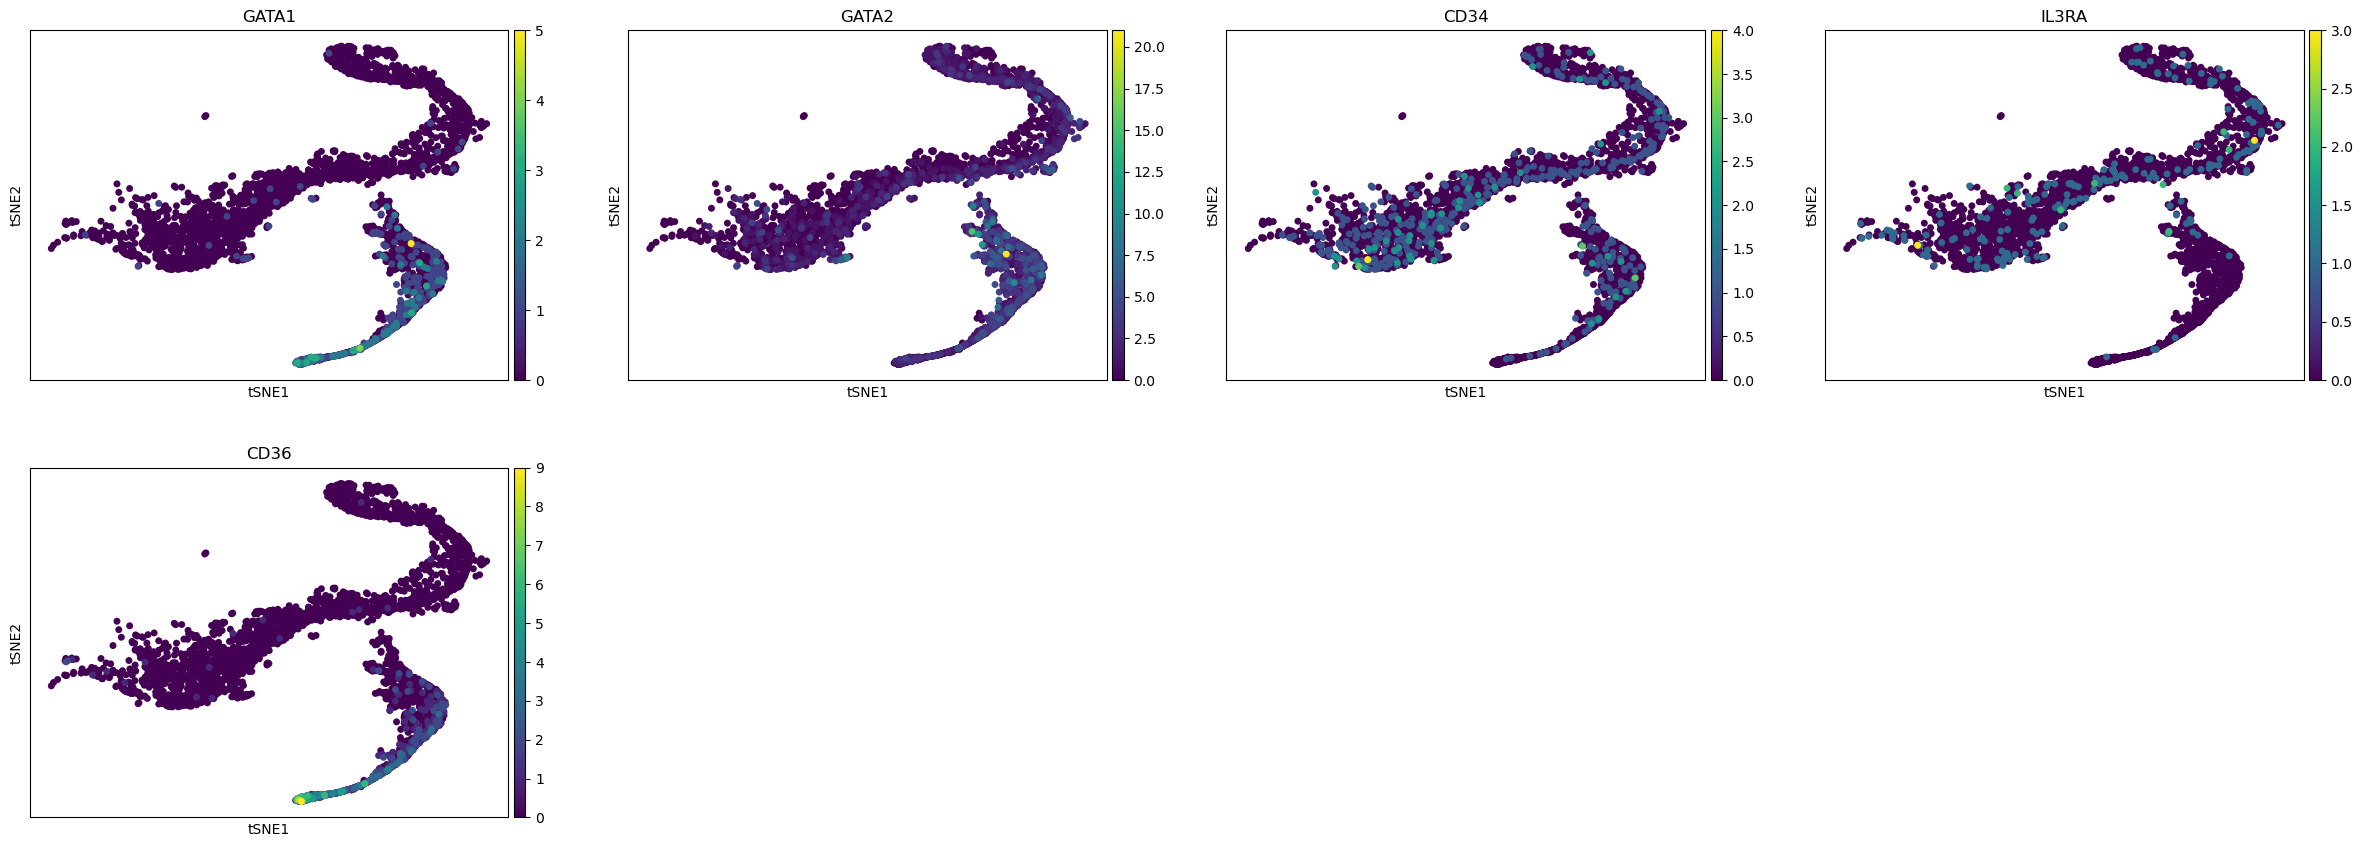

In [16]:
sc.pl.tsne(adata,color=['GATA1','GATA2','CD34','IL3RA','CD36'],s=100)

In [17]:
x = adata.obsm['X_tsne']

# Select genes

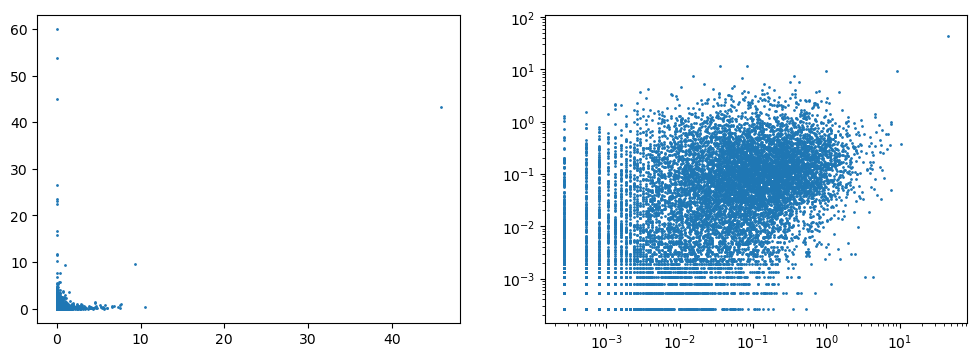

In [18]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [19]:
idx = (adata.layers["unspliced"].toarray().mean(0) > 0) 
U = adata.layers["unspliced"][:,idx].toarray()
n,p = U.shape
X = U
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
su = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total U counts =", str(su))


idx = adata.layers["spliced"].toarray().mean(0) > 0
S = adata.layers["spliced"][:,idx].toarray()
n,p = S.shape
X = S
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
ss = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total S counts =", str(ss))

idx = (adata.layers["spliced"].toarray().mean(0) > 0) | (adata.layers["unspliced"].toarray().mean(0) > 0)
U=adata.layers["unspliced"][:,idx].toarray()
S=adata.layers["spliced"][:,idx].toarray()
X = S + U
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s1 = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total counts =", str(s1))

X_total = X.sum(1)
s2 = (X_total.var()-X_total.mean())/X_total.mean()**2
print("s estimated by total counts =", str(s2))

s estimated by normalized covariance of total U counts = 0.15512069416578195
s estimated by normalized covariance of total S counts = 0.22314175828210697
s estimated by normalized covariance of total counts = 0.1754039688256909
s estimated by total counts = 0.21357604000503952


s estimated by normalized covariance of Poission genes = 0.14718328200540065


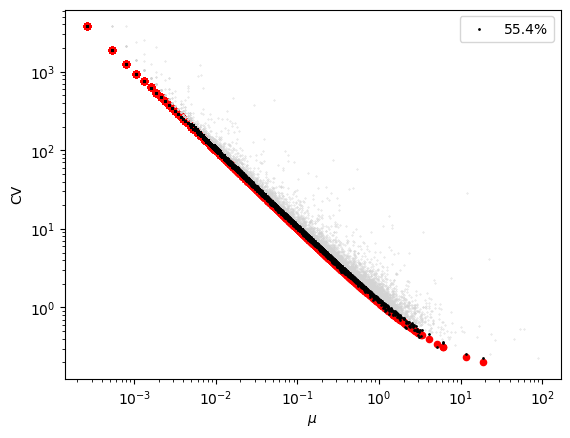

In [20]:
a=1
s=s1

X_bar = np.mean(U + S, axis=0)
X_var = np.var(U + S, axis=0)

Pgene_mask = (X_mean > 0) & (X_var/(a*X_mean + s*X_mean**2) < 1.1)
Pgenes = adata.var_names[idx][Pgene_mask]

P = (S + U)[:,Pgene_mask]
n,p = P.shape
P_cov = np.cov(P,rowvar=False)
P_mean = np.mean(P,axis=0)
P_rho = P_cov/P_mean[:,None]/P_mean[None,:]
s = (np.sum(P_rho)-np.sum(np.diag(P_rho)))/((p-1)*p)
print("s estimated by normalized covariance of Poission genes =", str(s))

plt.scatter(X_bar[Pgene_mask], a/X_bar[Pgene_mask] + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

read_depth =  (U + S)[:,Pgene_mask].sum(1)
rd = read_depth/read_depth.mean()

s estimated by normalized covariance of Poission genes = 0.14643141758824976


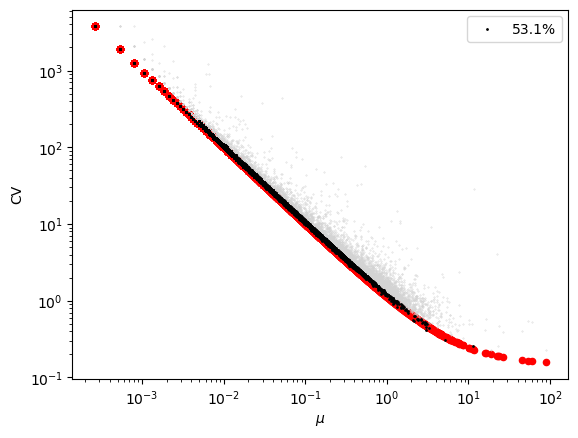

In [24]:
Pgene_mask = (X_mean > 0) & (X_var/(a*X_mean + s*X_mean**2) < 1.1)
Pgenes = adata.var_names[idx][Pgene_mask]

P = (S + U)[:,Pgene_mask]
n,p = P.shape
P_cov = np.cov(P,rowvar=False)
P_mean = np.mean(P,axis=0)
P_rho = P_cov/P_mean[:,None]/P_mean[None,:]
s = (np.sum(P_rho)-np.sum(np.diag(P_rho)))/((p-1)*p)
print("s estimated by normalized covariance of Poission genes =", str(s))

plt.scatter(X_bar, a/X_bar + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

read_depth =  (U + S)[:,Pgene_mask].sum(1)
rd = read_depth/read_depth.mean()

In [25]:
var_threshold = 1.2
U_mean = adata.layers["unspliced"].toarray().mean(0)
S_mean = adata.layers["spliced"].toarray().mean(0)
U_var = adata.layers["unspliced"].toarray().var(0)
S_var = adata.layers["spliced"].toarray().var(0)
fitted_idx = (U_mean > 0.1) & (S_mean > 0.1) \
    & (np.abs(np.log(S_mean/U_mean)) < 4) \
    & (U_var/(a*U_mean + s2*U_mean**2) > var_threshold) \
    & (S_var/(a*S_mean + s2*S_mean**2) > var_threshold)
fitted_genes=adata.var_names[fitted_idx]

/tmp/ipykernel_2459435/2383141038.py:7: RuntimeWarning: divide by zero encountered in divide
  & (np.abs(np.log(S_mean/U_mean)) < 4) \
/tmp/ipykernel_2459435/2383141038.py:7: RuntimeWarning: invalid value encountered in divide
  & (np.abs(np.log(S_mean/U_mean)) < 4) \
/tmp/ipykernel_2459435/2383141038.py:7: RuntimeWarning: divide by zero encountered in log
  & (np.abs(np.log(S_mean/U_mean)) < 4) \
/tmp/ipykernel_2459435/2383141038.py:8: RuntimeWarning: invalid value encountered in divide
  & (U_var/(a*U_mean + s2*U_mean**2) > var_threshold) \
/tmp/ipykernel_2459435/2383141038.py:9: RuntimeWarning: invalid value encountered in divide
  & (S_var/(a*S_mean + s2*S_mean**2) > var_threshold)


In [26]:
fitted_genes = fitted_genes[fitted_genes.isin(gene_name)]
fitted_idx = adata.var_names.isin(fitted_genes)

In [27]:
cell_cycle_genes = np.loadtxt("data/cell_cycle_genes.txt",dtype="str")
fitted_genes = fitted_genes[~fitted_genes.isin(cell_cycle_genes)]
len(fitted_genes)

149

/tmp/ipykernel_2459435/2755882506.py:2: RuntimeWarning: divide by zero encountered in divide
  ax[0].scatter(S_mean, a/S_mean + s2, c='r', s=20)
/tmp/ipykernel_2459435/2755882506.py:3: RuntimeWarning: invalid value encountered in divide
  ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=1)
/tmp/ipykernel_2459435/2755882506.py:7: RuntimeWarning: divide by zero encountered in divide
  ax[1].scatter(U_mean, a/U_mean + s2, c='r', s=20)
/tmp/ipykernel_2459435/2755882506.py:8: RuntimeWarning: invalid value encountered in divide
  ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=1)


(3775, 149, 2)

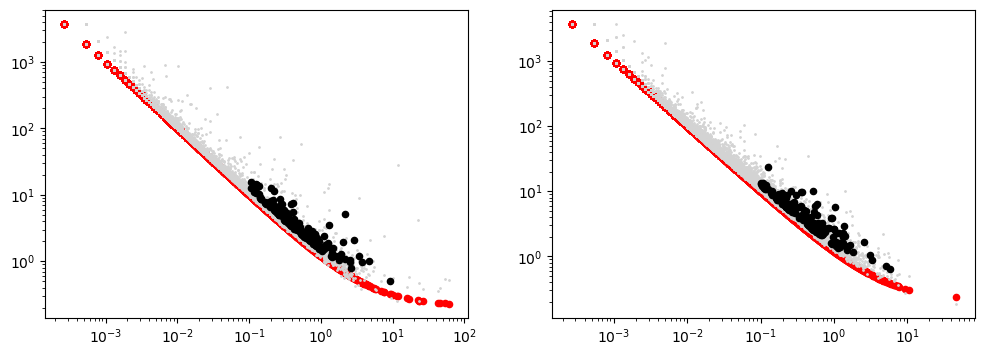

In [28]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(S_mean, a/S_mean + s2, c='r', s=20)
ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=1)
ax[0].scatter(S_mean[fitted_idx], S_var[fitted_idx]/S_mean[fitted_idx]**2, c='k', s=20)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(U_mean, a/U_mean + s2, c='r', s=20)
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=1)
ax[1].scatter(U_mean[fitted_idx], U_var[fitted_idx]/U_mean[fitted_idx]**2, c='k', s=20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

X=np.zeros((n,fitted_idx.sum(),2))
X[:,:,0]=adata.layers["unspliced"][:,fitted_idx].toarray()
X[:,:,1]=adata.layers["spliced"][:,fitted_idx].toarray()
fitted_genes=adata.var_names[fitted_idx]
X.shape

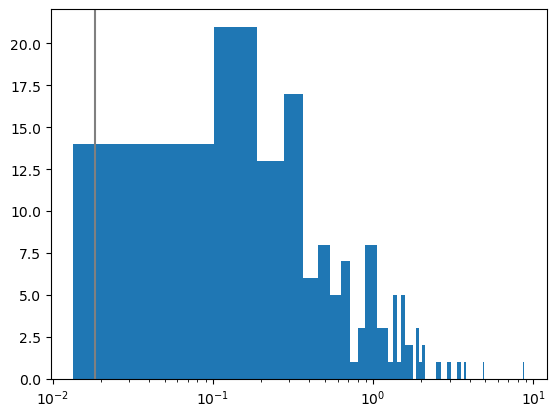

In [29]:
Ub_gene_idx = np.array([ np.where(gene_name == fitted_gene)[0][0]  for fitted_gene in fitted_genes ])
Ub = 10**(-5)*gene_length[Ub_gene_idx]
plt.hist(Ub,bins=100);
plt.xscale('log')
plt.axvline(x=np.e**(-4),color='gray');

In [30]:
plot_idx = [np.where(fitted_genes==gene)[0] for gene in marker_genes]
plot_idx = np.concatenate(plot_idx).ravel()
print(fitted_genes[plot_idx])

Index(['CD36', 'ITGA2B'], dtype='object', name='index')


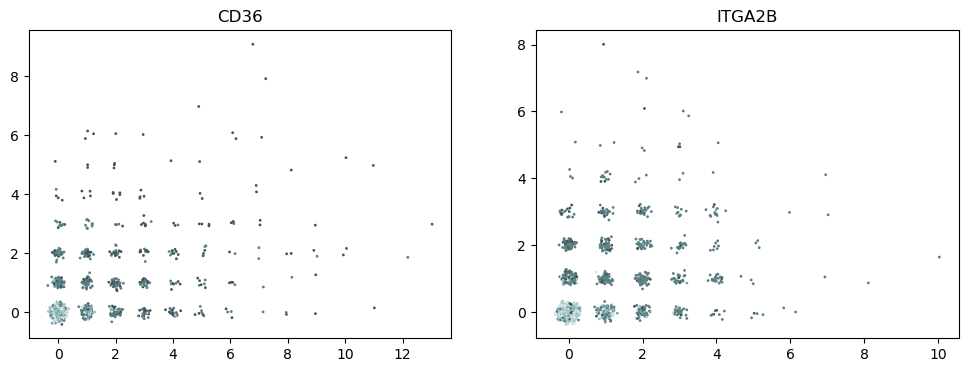

In [31]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=1,alpha=1,c=cell_colors)

# Mixtures fitting

In [34]:
cell_idx = clusters.isin(Clusters)
X_mix = X[cell_idx]

In [35]:
PMs = []
for nc in range(1,7):
    PM = PoissonMixture(n_components=nc,verbose=0)
    Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=5,n_init=3)
    PMs.append(PM)
    print(nc,elbo,PM.compute_AIC(X_mix),PM.compute_BIC(X_mix))

1 -291.0603394152772 -291.1392798126282 -291.38542211556614
2 -270.06704111256505 -270.22508744078476 -270.71819802754305
3 -266.18549085016593 -266.16811135535266 -266.9081902259312
4 -263.5276291136561 -263.70294533055215 -264.689992484951
5 -262.25626666928383 -262.3594168908414 -263.59343232906053
6 -261.35440926428146 -261.6822352878547 -263.1632190098942


In [36]:
PM = PoissonMixture(n_components=2,verbose=0)
Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=10,n_init=5)
PM.weights

array([0.26494031, 0.73505969])

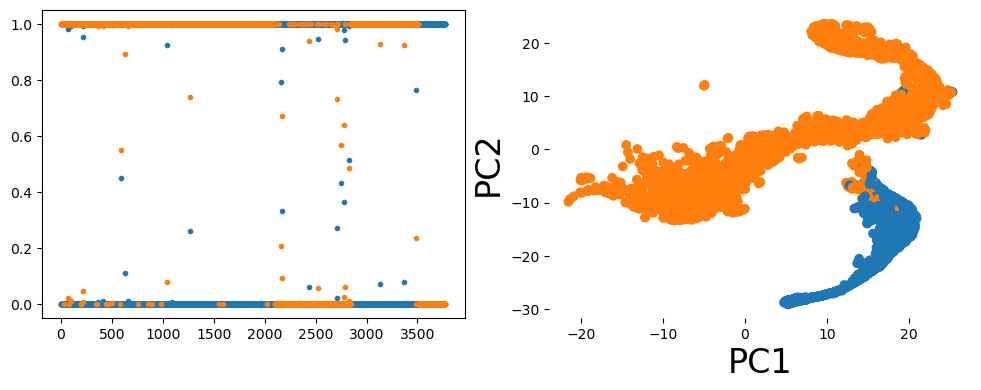

In [37]:
tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters[cell_idx])],'.');
ax[1].scatter(x[cell_idx,0],x[cell_idx,1],c=tab_colors[np.argmax(Q,axis=1)]);
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

[0.29393358 0.26074475 0.44532167]


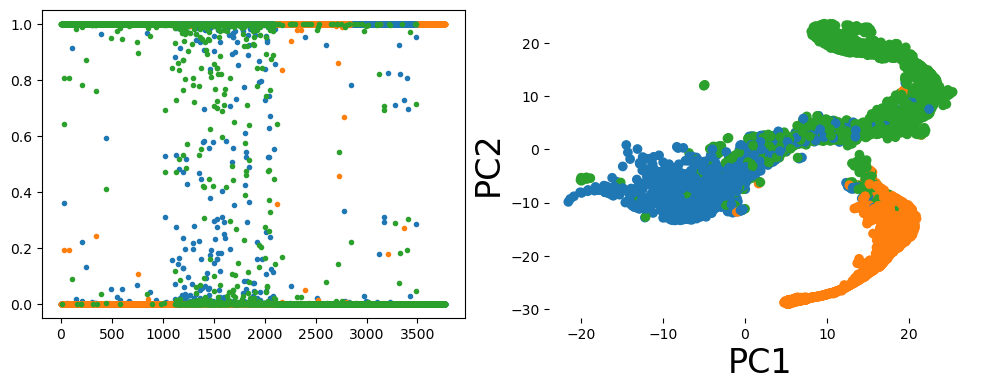

In [38]:
PM = PoissonMixture(n_components=3,verbose=0)
Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=10,n_init=5)
print(PM.weights)

tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters[cell_idx])],'.');
ax[1].scatter(x[cell_idx,0],x[cell_idx,1],c=tab_colors[np.argmax(Q,axis=1)]);
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

[0.42748473 0.11245691 0.28268162 0.17737674]


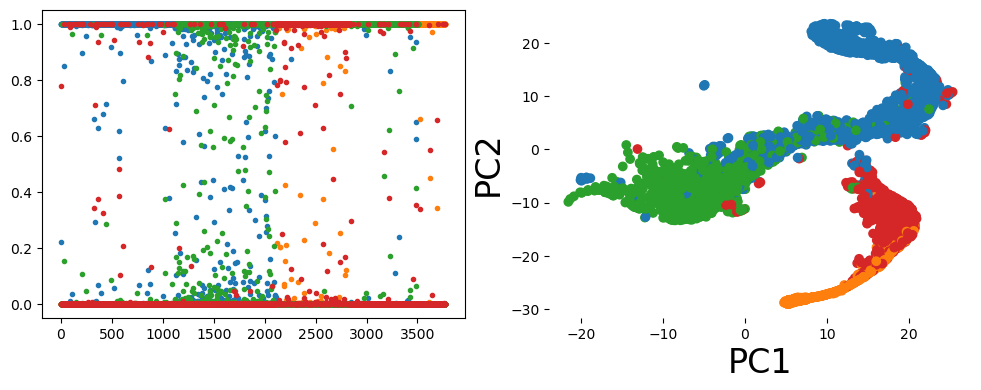

In [39]:
PM = PoissonMixture(n_components=4,verbose=0)
Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=10,n_init=5)
print(PM.weights)

tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters[cell_idx])],'.');
ax[1].scatter(x[cell_idx,0],x[cell_idx,1],c=tab_colors[np.argmax(Q,axis=1)]);
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

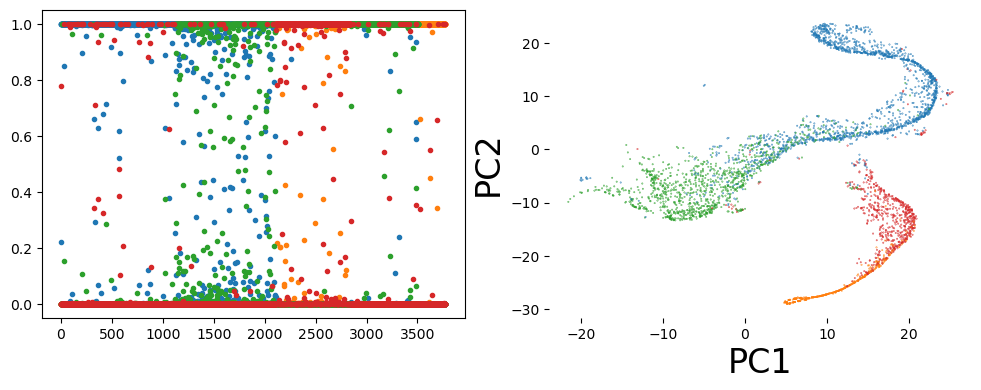

In [40]:
tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters[cell_idx])],'.');
ax[1].scatter(x[cell_idx,0],x[cell_idx,1],c=tab_colors[np.argmax(Q,axis=1)],s=0.1);
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

In [1]:
gbr = PM.theta[:,:,0]/PM.theta[:,:,1]

plt.plot(gbr,'.-',alpha=0.1);
plt.yscale('log')

NameError: name 'PM' is not defined

# Trajectory fitting

In [44]:
elbos = {}
traj_params={'r':rd,"Ub":Ub,"lambda_tau":0,"lambda_a":0}

## Fine cluster

In [79]:
m=100
weight0 = np.zeros((adata.n_obs,m))
Prior_Clusters = [['HSC_1', 'HSC_2', 'Precursors'], ['Ery_1','Ery_2']]
for i,Cluster in enumerate(Prior_Clusters):
    idx = clusters.isin(Cluster)
    print(idx.sum())
    weight0[idx,int(i*m/len(Prior_Clusters)):int((i+1)*m/len(Prior_Clusters))] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
weight0=np.flip(weight0,axis=-1)
Q0 = weight0[:,None]

2768
1007


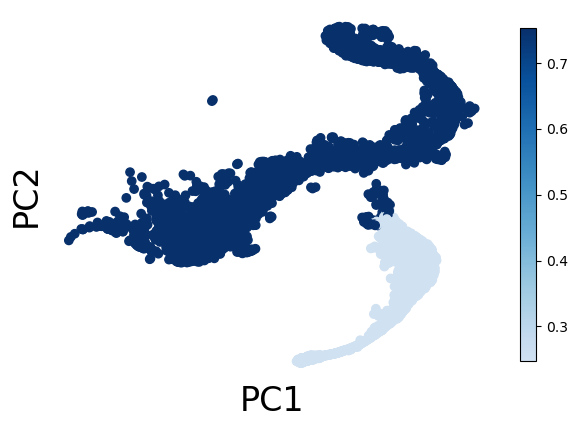

In [80]:
t_hat = np.sum(Q0@(np.linspace(0,1,m).reshape((-1,1))),axis=1)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=t_hat,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [76]:
topo = np.array([[0,1,2]])
tau = (0,1,2)
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=traj_params,Q=Q0,parallel=True,n_threads=10,epoch=100)
print(traj.elbos[-1])

fitting with warm start


100%|██████████| 100/100 [02:29<00:00,  1.50s/it]

-266.0990852081745


[0.         1.14153464 2.        ]


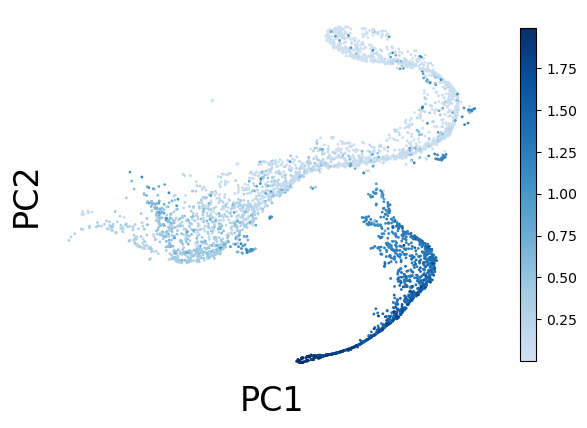

In [77]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y,s=1);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [81]:
topo = np.array([[0,1,2,3]])
tau = (0,1,2,3)
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=traj_params,Q=Q0,parallel=True,n_threads=10,epoch=100)
print(traj.elbos[-1])

fitting with warm start


100%|██████████| 100/100 [03:01<00:00,  1.81s/it]

-262.8343384328475


[0.         0.56157961 1.85830779 3.        ]


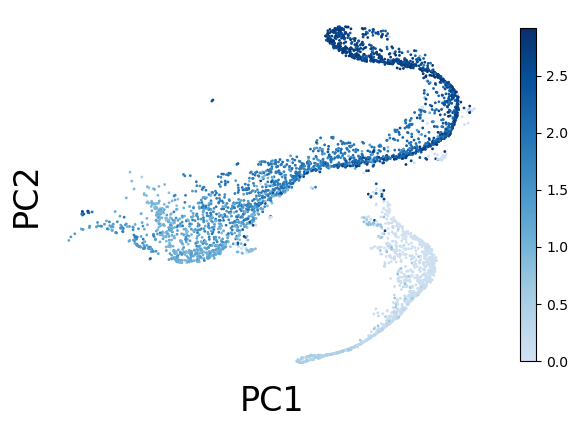

In [82]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y,s=1);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

[]

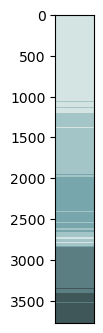

In [61]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    cluster[idx] = i
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
fig, ax = plt.subplots(1,1,figsize=(0.5,4))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_cluster)
ax.set_xticks([])

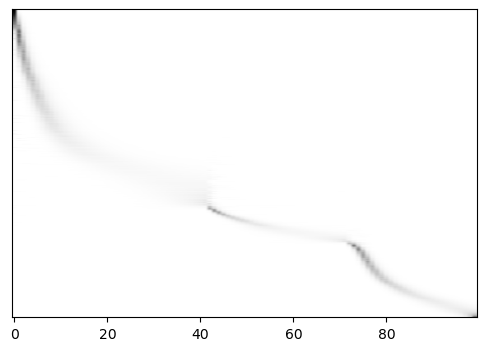

In [62]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax=plot_t(traj,l=0,ax=ax,order_cells=True)
ax.set_yticks([]);

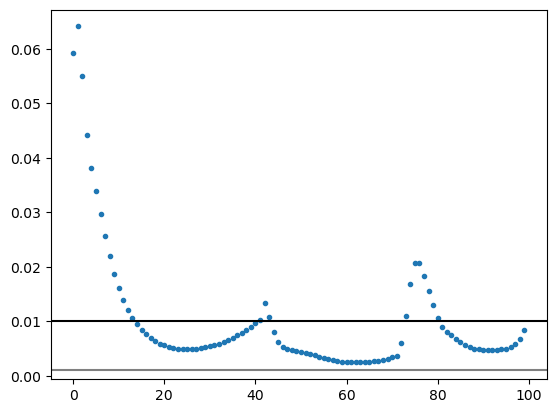

In [63]:
plt.plot(traj.Q[:,0].mean(0),'.')
plt.axhline(y=1/traj.m,c='k')
plt.axhline(y=0.1/traj.m,c='gray')

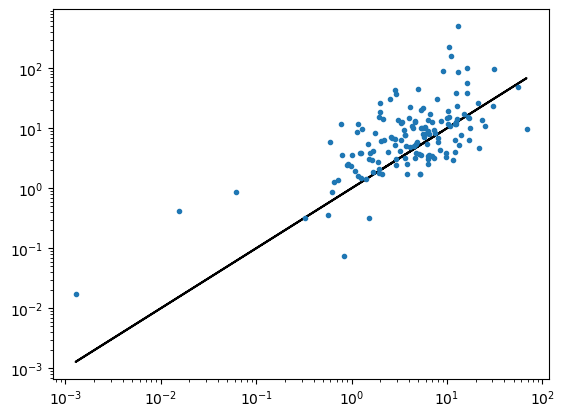

In [75]:
plt.loglog(traj.theta[:,-2],traj.theta[:,-2],'k');
plt.loglog(traj.theta[:,-2],traj.theta[:,-1],'.');

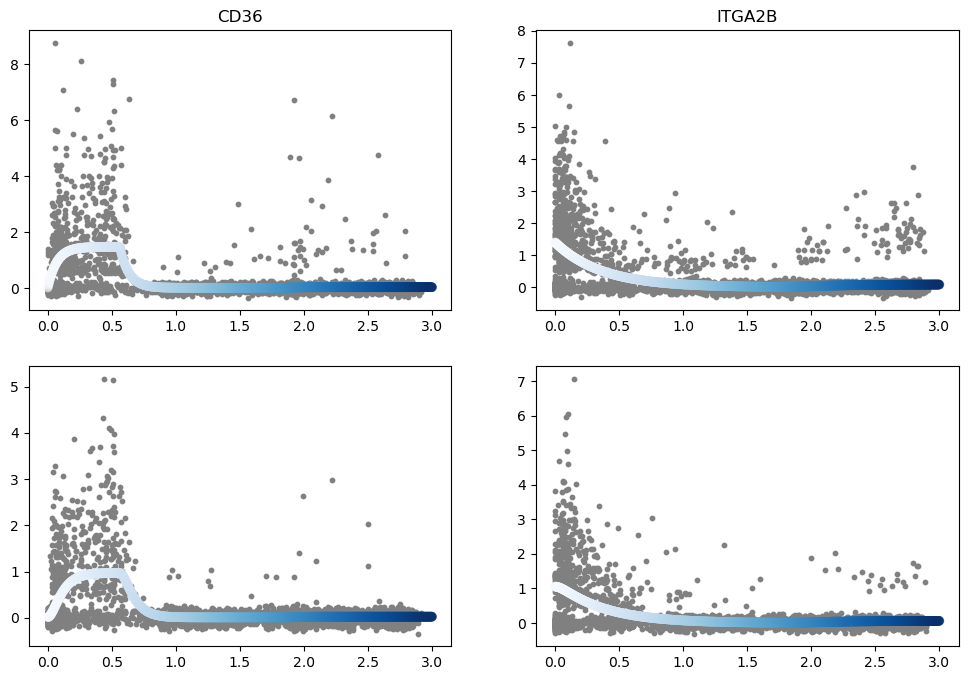

In [83]:
plot_y(traj,X=X/rd[:,None,None],idx=plot_idx,gene_name=fitted_genes);

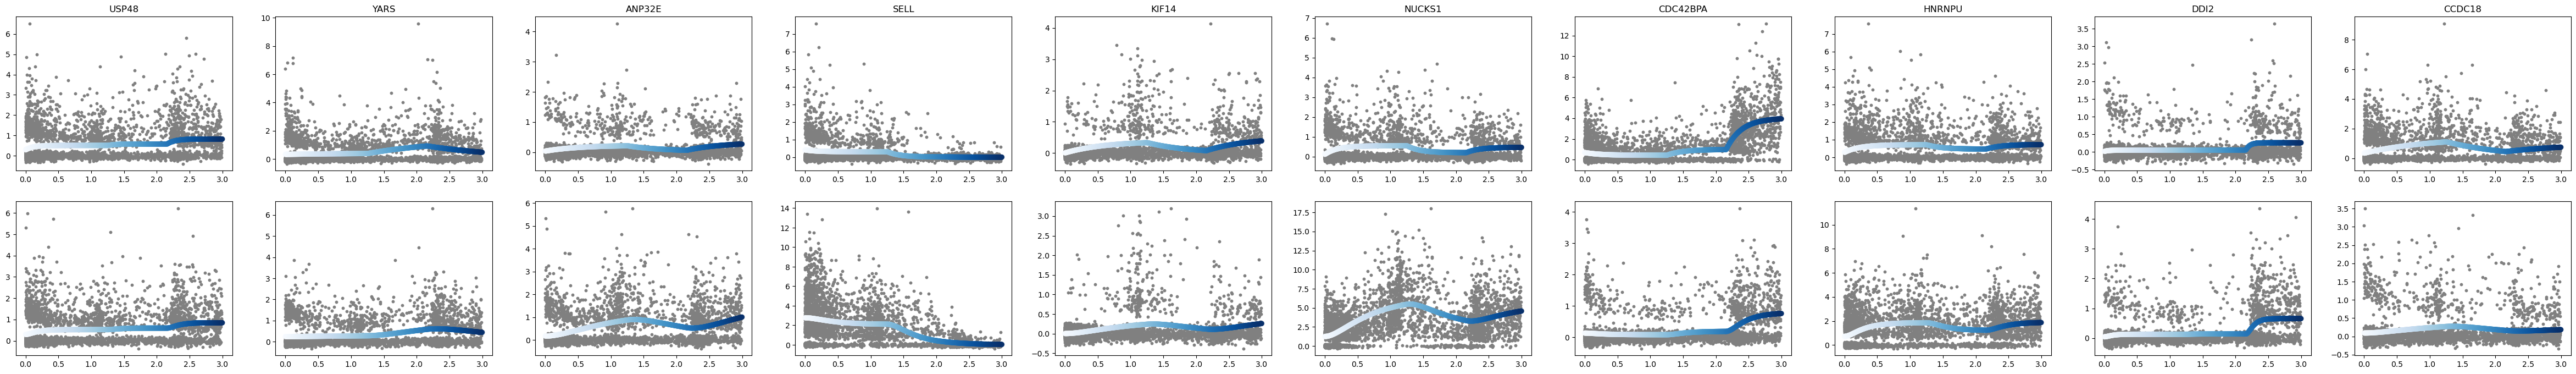

In [66]:
plot_y(traj,X=X/rd[:,None,None],idx=np.arange(10),gene_name=fitted_genes);

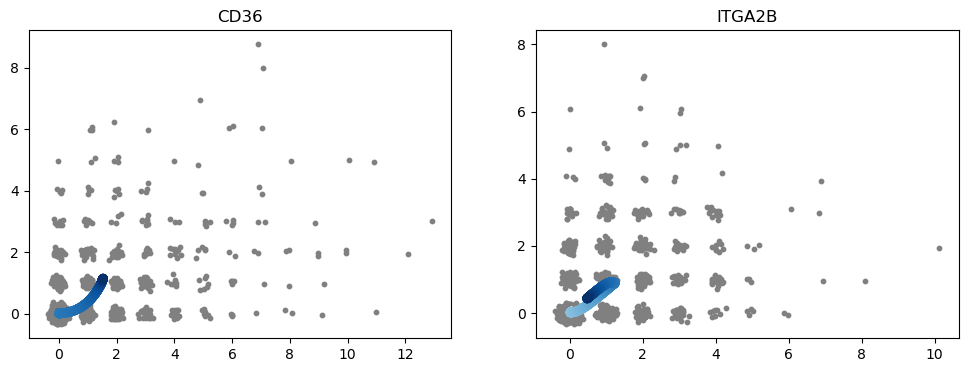

In [67]:
plot_phase(traj,X=X,idx=plot_idx,gene_name=fitted_genes);

3


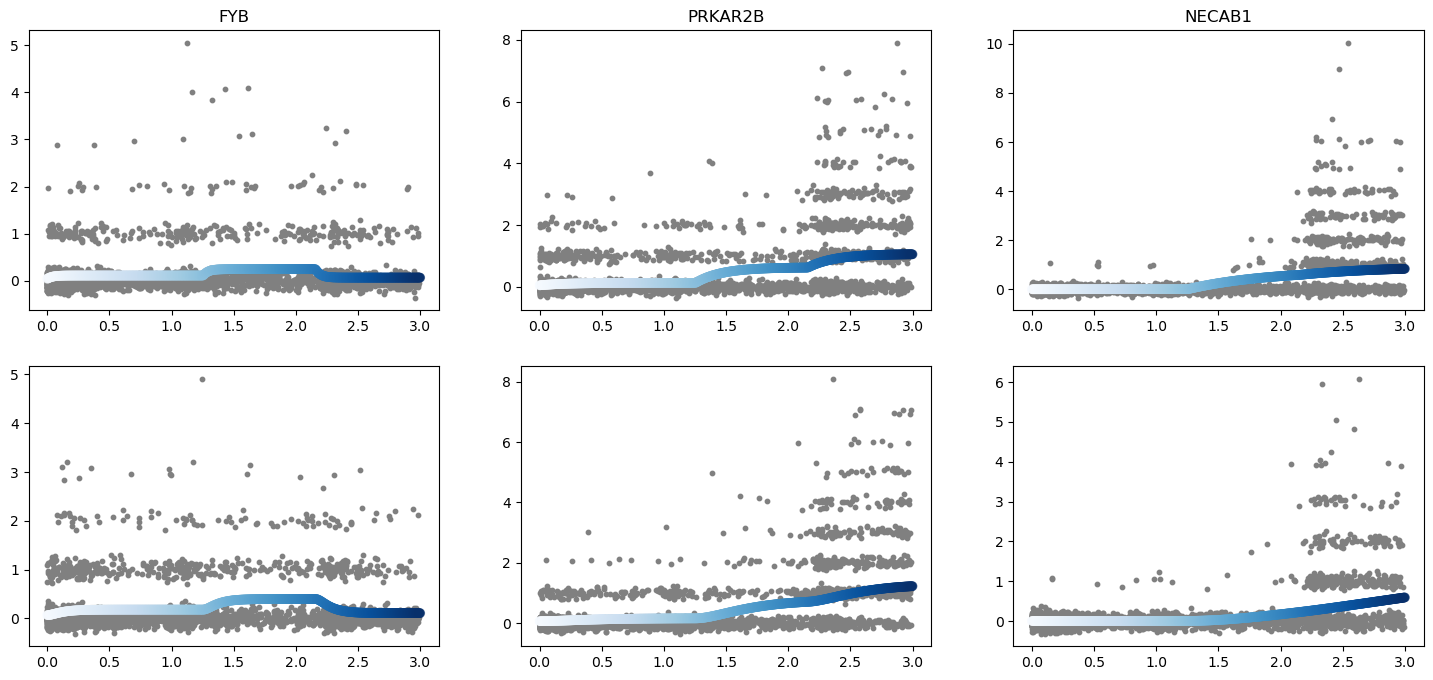

In [68]:
n, p, _ = X.shape
up_mask = (traj.theta[:,2] > 2*traj.theta[:,1]) & (traj.theta[:,1] > 2*traj.theta[:,0])
print(up_mask.sum())
up_idx = np.arange(p)[up_mask]
plot_y(traj,X=X,idx=up_idx[:10],gene_name=fitted_genes);

In [69]:
plot_marker_genes = ['CD34','GATA1',"GATA2",'ITGA2B']

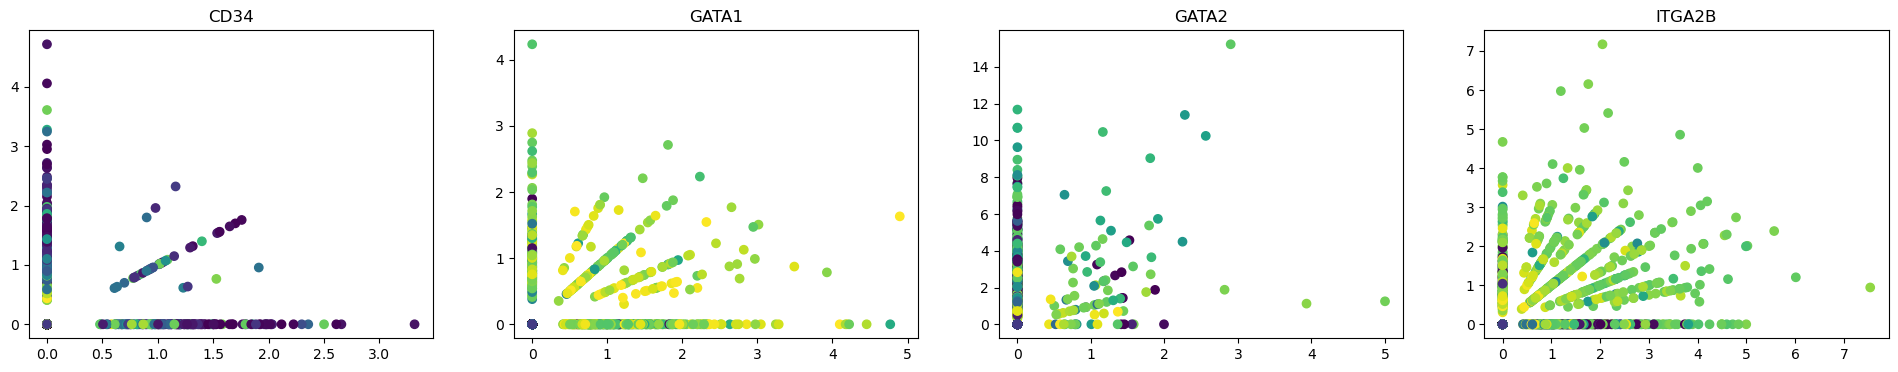

In [70]:
fig,ax = plt.subplots(1,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),4))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[i].set_title(gene)
    ax[i].scatter(adata.layers["unspliced"].toarray()[:,j]/rd,adata.layers["spliced"].toarray()[:,j]/rd,c=traj.Q[:,0]@traj.t)

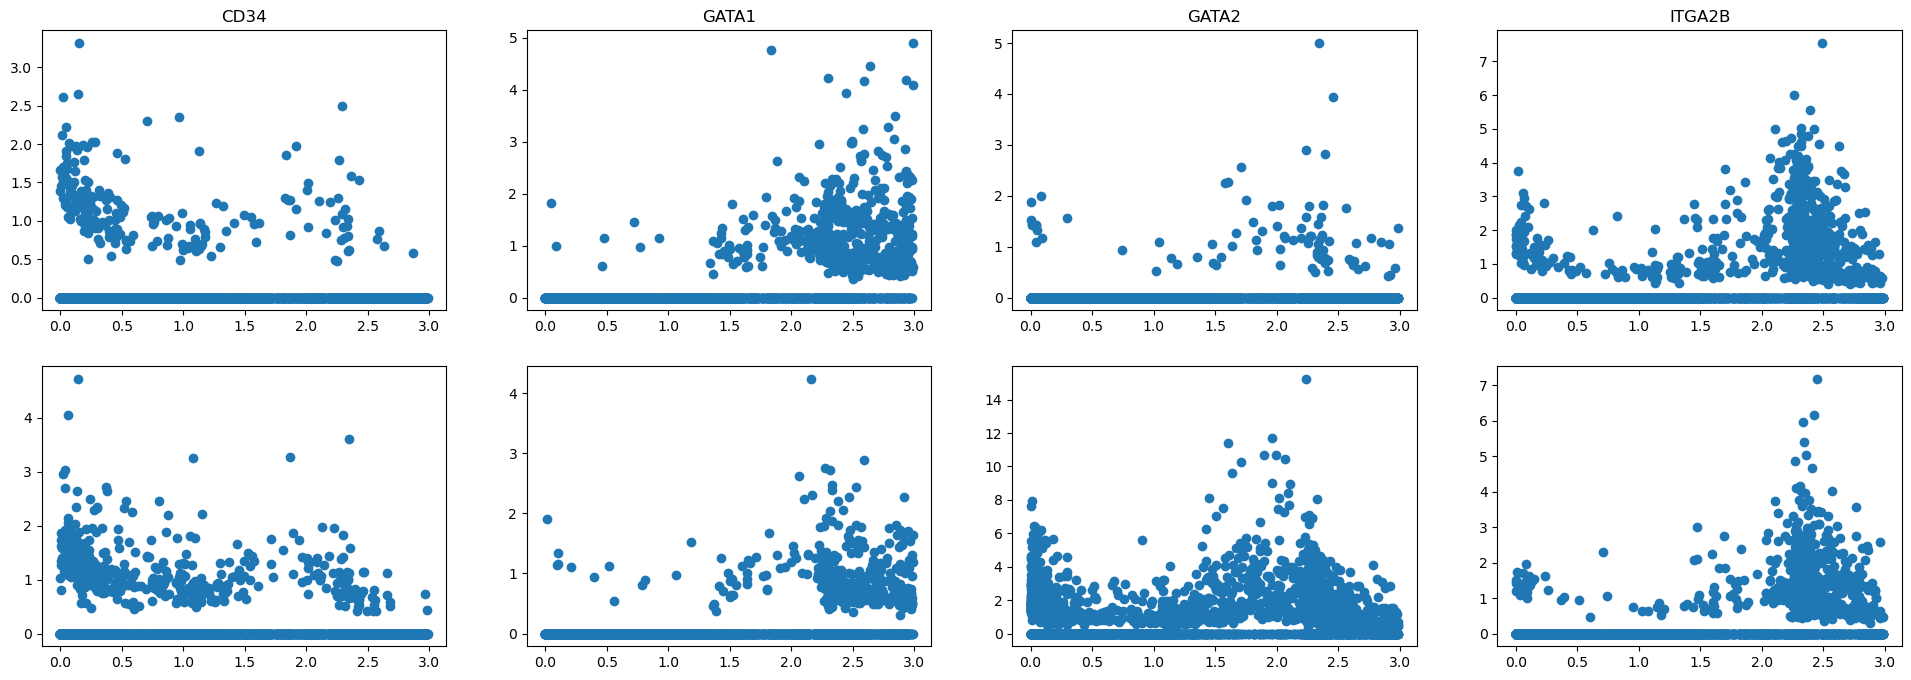

In [71]:
fig,ax = plt.subplots(2,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),8))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

[Text(0, 0, 'α0'), Text(1, 0, 'α1'), Text(2, 0, 'α2')]

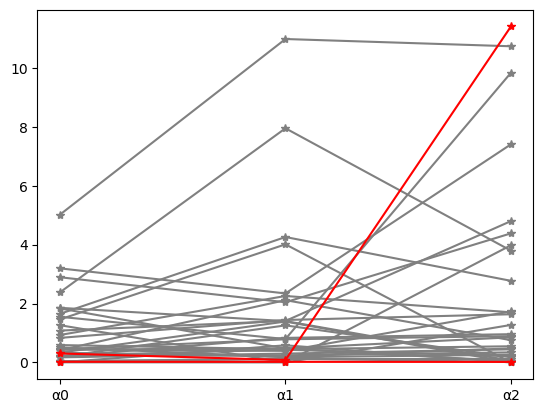

In [72]:
p=30
fig,ax = plt.subplots(1,1)
for j in range(p):
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='gray')
for j in plot_idx:
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='red')

x_label_list = ['α0', 'α1', 'α2']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)
#plt.yscale('log')

In [73]:
#from scipy.spatial import distance

#S = data.X.toarray()
#dist = distance.cdist(S, S, 'minkowski', p=1.)

#order = np.argsort(data.obs["t_hat"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

#order = np.argsort(data.obs["celltype"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

## Fitting without prior

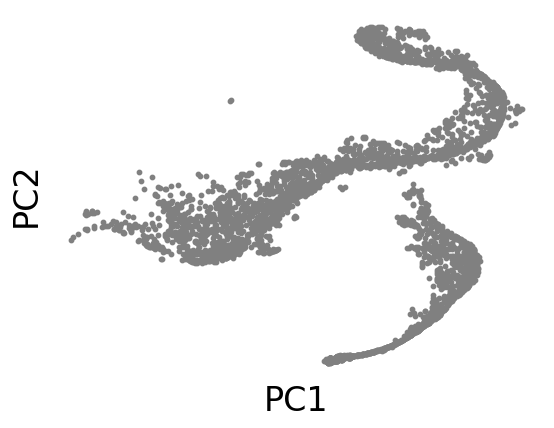

In [74]:
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c='grey',s=10);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

### two_species_ss

In [49]:
from multiprocessing import Pool

tau = (0,1,2)
topo = np.array([[0,1,2]])
Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,params=traj_params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

Text(0.5, 1.0, 'Random initialiazation')

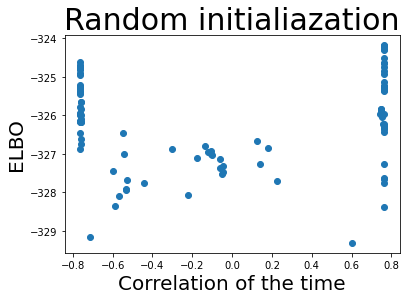

In [50]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [51]:
traj = trajs[np.argmax(elbos)]
np.max(elbos)

-324.1817779813873

[ 0.         22.21300029 48.        ]


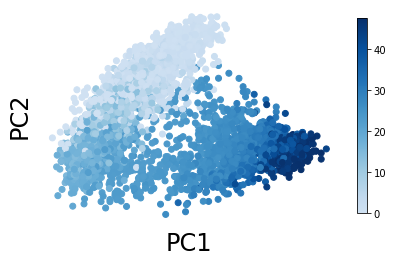

In [52]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

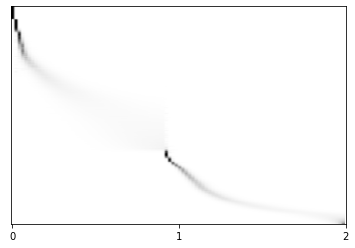

In [53]:
ax = plot_t(traj,l=0,order_cells=True)
x_label_list = ['0', '1', '2']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list);
ax.set_yticks([]);

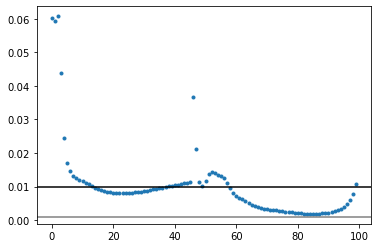

In [54]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.')
plt.axhline(y=1/traj.m,c='k')
plt.axhline(y=0.1/traj.m,c='gray')

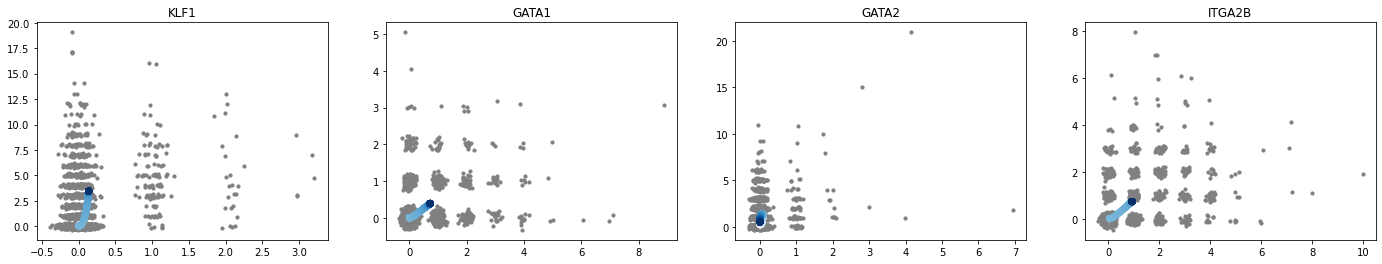

In [55]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes);

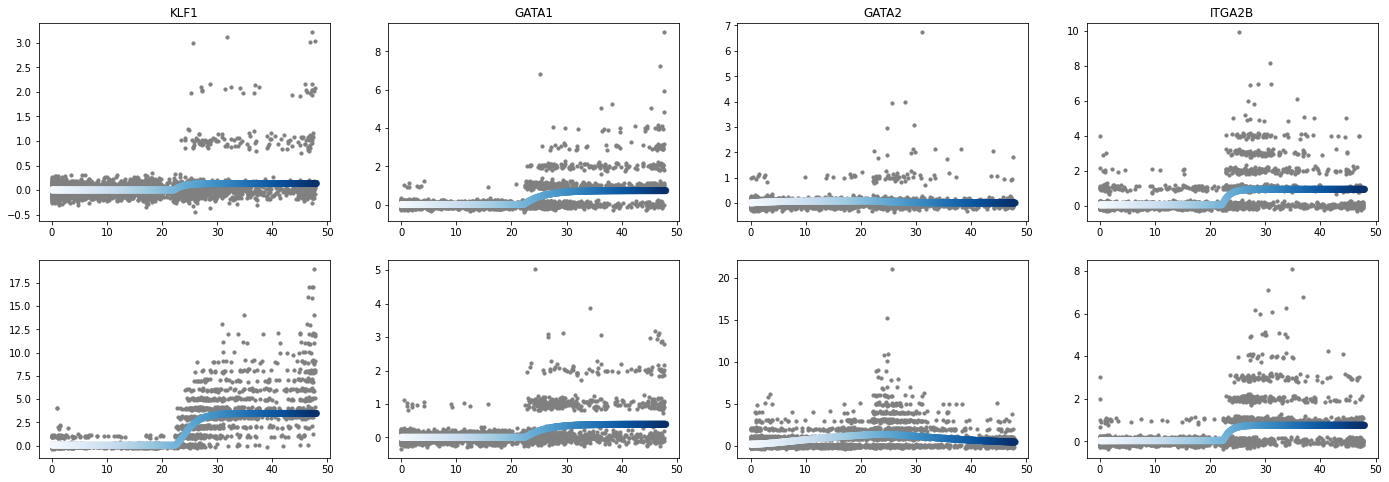

In [56]:
plot_y(traj,idx=plot_idx,gene_name=fitted_genes);

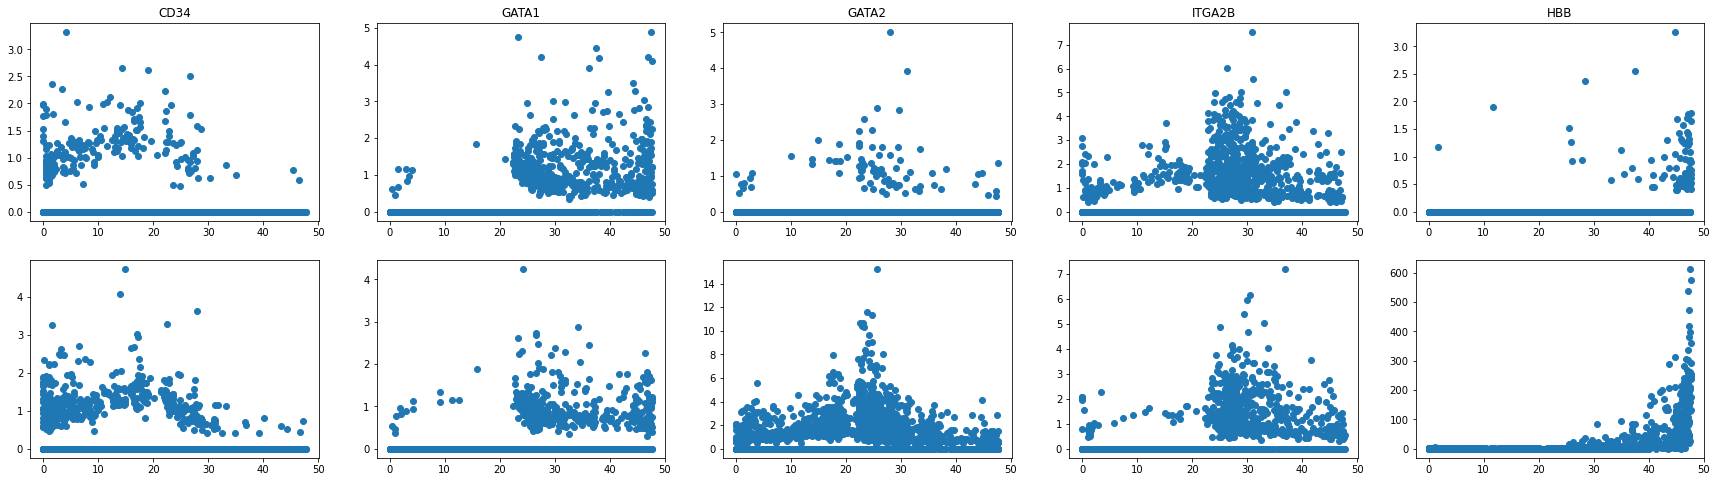

In [57]:
plot_marker_genes = ['CD34','GATA1','GATA2','ITGA2B','HBB']
fig,ax = plt.subplots(2,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),8))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

17


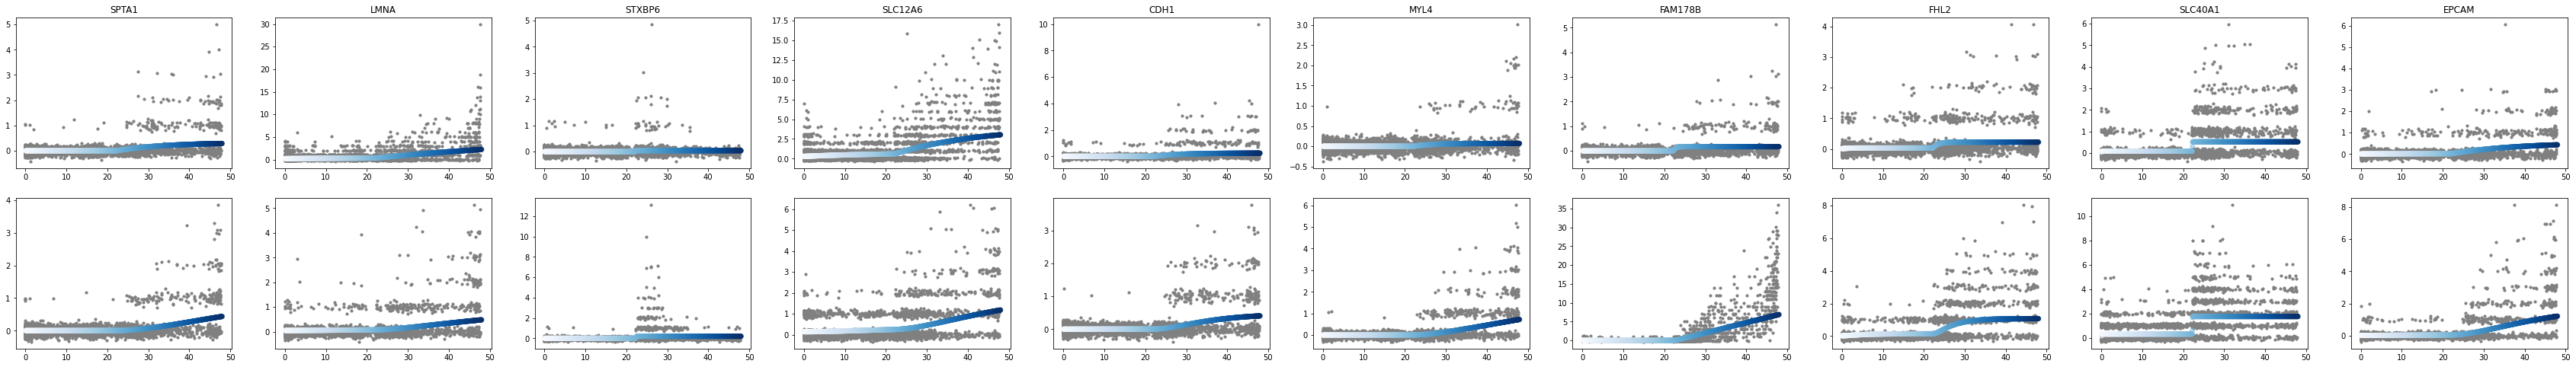

In [58]:
n, p, _ = X.shape
up_mask = (traj.theta[:,2] > 2*traj.theta[:,1]) & (traj.theta[:,1] > 2*traj.theta[:,0])
print(up_mask.sum())
up_idx = np.arange(p)[up_mask]
plot_y(traj,X=X,idx=up_idx[:10],gene_name=fitted_genes);

### two_species_ss_tau

In [59]:
tau = (0,24,48)
topo = np.array([[0,1,2]])
trajs = []
for seed in tqdm(range(20)):
    traj = Trajectory(topo, tau,  model="two_species_ss_tau", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)

  0%|          | 0/20 [00:00<?, ?it/s]


NameError: name 'params' is not defined

In [ ]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [ ]:
traj = trajs[np.argmax(elbos)]

In [ ]:
plt.hist(traj.theta[:,-3])

In [ ]:
plot_y(traj,idx=plot_idx,gene_name=fitted_genes);

### two_species

In [ ]:
tau = (0,24,48)
topo = np.array([[0,1,2]])
trajs = []
for seed in tqdm(range(100)):
    traj = Trajectory(topo, tau,  model="two_species", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, fit_tau=True, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)

In [ ]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [ ]:
traj = trajs[np.argmax(elbos)]
traj.elbos[0][-1]

In [ ]:
plt.scatter(traj.theta[:,-3],traj.theta[:,0]*traj.theta[:,-2]/traj.theta[:,-1])
plt.plot(traj.theta[:,-3],traj.theta[:,-3],color="lightgray")

In [ ]:
traj = trajs[np.argmax(corrs)]
traj.elbos[0][-1]

In [ ]:
plt.scatter(traj.theta[:,-3],traj.theta[:,0]*traj.theta[:,-2]/traj.theta[:,-1])
plt.plot(traj.theta[:,-3],traj.theta[:,-3],color="lightgray")

# Synthetic data

In [ ]:
m=100
weight0 = np.zeros((adata.n_obs,m))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    weight0[idx,int(i*m/len(Clusters)):int((i+1)*m/len(Clusters))] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

topo = np.array([[0,1,2]])
tau = (0,24,48) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=params,Q=Q0,parallel=True,n_threads=4,epoch=10)

In [ ]:
print(traj.elbos[-1])

In [ ]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [ ]:
plot_t(traj,order_cells=True)

In [ ]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum()*traj.m,'.')

In [ ]:
Y = traj.get_Y_hat(theta=traj.theta,t=traj.Q[:,0]@traj.t,tau=traj.tau,topo=traj.topo,params=traj.params)
syn_X = np.random.poisson(rd[:,None,None]*Y[0])
syn_t = traj.Q[:,0]@traj.t
plt.hist(syn_t,bins=traj.t);

In [ ]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

In [ ]:
syn_tau = traj.tau.copy()
syn_topo = traj.topo.copy()
trajs = []
for seed in tqdm(range(20)):
    syn_traj = Trajectory(syn_topo, syn_tau,  model="two_species_ss", restrictions={}, verbose=0)
    syn_traj = syn_traj.fit(syn_X, warm_start=False, fit_tau=False, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=4, seed=seed)
    trajs.append(syn_traj)

In [ ]:
corrs = []
elbos = []
for syn_traj in trajs:
    right_t = syn_t
    t_hat = syn_traj.Q[:,0] @ syn_traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( syn_traj.elbos[np.argmax([syn_traj.elbos[i][-1] for i in range(len(syn_traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)